# imports

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from collections import deque

# pTE

In [109]:
# -*- coding: utf-8 -*-

# Copyright (c) 2020 Riccardo Silini
# Adapted and modified from a MATLAB routine written by M. Chavez

"""Functions to compute pseudo transfer entropy (pTE).

This module provides a set of functions to compute pTE between different
time series.

Functions
---------------------

  * normalisa -- L2 normalization, can be replaced by the 
    sklearn.preprocessing.normalize(*args) function
  * embed -- generates matrices containing segments of the original time
    series, depending on the embedding size chosen.
  * timeshifted -- creeates time shifted surrogates. The sign on the shift means
    that the time series that must be shifted is the independent one
  * pTE -- Computes the pseudo transfer entropy between time series.

Libraries required
---------------------
import numpy as np
import scipy.signal as sps
from collections import deque

"""

def normalisa(a, order=2, axis=-1):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def embed(x, embd, lag):
    N = len(x)
    hidx = np.arange(embd * lag, step=lag)
    vidx = np.arange(N - (embd - 1) * lag)
    vidx = vidx.T
    Nv = len(vidx)
    U = np.array([x, ] * embd)
    W = np.array([hidx, ] * Nv).T + np.array([vidx, ] * embd)
    u = np.zeros((embd, Nv))
    for i in range(embd):
        for j in range(Nv):
            u[i, j] = U[i, W[i, j]]
    return u.T

def timeshifted(timeseries, shift):
    ts = deque(timeseries)      
    ts.rotate(shift)
    return np.asarray(ts)   

def iaaft(x, maxiter=1000, atol=1e-8, rtol=1e-10):
    """Return iterative amplitude adjusted Fourier transform surrogates.
    this function have been taken from teh NoLiTSA package, 
    Copyright (c) 2015-2016, Manu Mannattil.
    All rights reserved.

    Returns phase randomized, amplitude adjusted (IAAFT) surrogates with
    the same power spectrum (to a very high accuracy) and distribution
    as the original data using an iterative scheme (Schreiber & Schmitz
    1996).

    Parameters
    ----------
    x : array
        1-D real input array of length N containing the time series.
    maxiter : int, optional (default = 1000)
        Maximum iterations to be performed while checking for
        convergence.  The scheme may converge before this number as
        well (see Notes).
    atol : float, optional (default = 1e-8)
        Absolute tolerance for checking convergence (see Notes).
    rtol : float, optional (default = 1e-10)
        Relative tolerance for checking convergence (see Notes).

    Returns
    -------
    y : array
        Surrogate series with (almost) the same power spectrum and
        distribution.
    i : int
        Number of iterations that have been performed.
    e : float
        Root-mean-square deviation (RMSD) between the absolute squares
        of the Fourier amplitudes of the surrogate series and that of
        the original series.

    Notes
    -----
    To check if the power spectrum has converged, we see if the absolute
    difference between the current (cerr) and previous (perr) RMSDs is
    within the limits set by the tolerance levels, i.e., if abs(cerr -
    perr) <= atol + rtol*perr.  This follows the convention used in
    the NumPy function numpy.allclose().

    Additionally, atol and rtol can be both set to zero in which
    case the iterations end only when the RMSD stops changing or when
    maxiter is reached.
    """
    # Calculate "true" Fourier amplitudes and sort the series.
    ampl = np.abs(np.fft.rfft(x))
    sort = np.sort(x)

    # Previous and current error.
    perr, cerr = (-1, 1)

    # Start with a random permutation.
    t = np.fft.rfft(np.random.permutation(x))

    for i in range(maxiter):
        # Match power spectrum.
        s = np.real(np.fft.irfft(ampl * t / np.abs(t), n=len(x)))

        # Match distribution by rank ordering.
        y = sort[np.argsort(np.argsort(s))]

        t = np.fft.rfft(y)
        cerr = np.sqrt(np.mean((ampl ** 2 - np.abs(t) ** 2) ** 2))

        # Check convergence.
        if abs(cerr - perr) <= atol + rtol * abs(perr):
            break
        else:
            perr = cerr

    # Normalize error w.r.t. mean of the "true" power spectrum.
    return y, i, cerr / np.mean(ampl ** 2)    

def pTE(z, tau=1, dimEmb=1, surr=None, Nsurr=19):
    """Returns pseudo transfer entropy.

    Parameters
    ----------
    z : array
        array of arrays, containing all the time series.
    tau : integer
        delay of the embedding.  
    dimEMb : integer
        embedding dimension, or model order.     
    surr : boolean
        if True it computes the maximum value obtained using 19 times shifted
        surrogates      

    Returns
    -------
    pte : array
        array of arrays. The dimension is (# time series, # time series). 
        The diagonal is 0, while the off diagonal term (i, j) corresponds
        to the pseudo transfer entropy from time series i to time series j.
    ptesurr : array
        array of arrays. The dimension is (# time series, # time series). 
        The diagonal is 0, while the off diagonal term (i, j) corresponds
        to the pseudo transfer entropy from time series i to surrogate time 
        series j.    
    In case of surrogates it returns pte and the maximum value obtained with 
    surrogares ptesurr   
    """

    NN, T = np.shape(z)
    Npairs = NN * (NN - 1)
    pte = np.zeros((NN, NN))
    ptesurr = np.zeros((NN, NN))  
    z = normalisa(sps.detrend(z))
    channels = np.arange(NN, step=1)

    for i in channels:
        EmbdDumm = embed(z[i], dimEmb + 1, tau)
        Xtau = EmbdDumm[:, :-1]
        for j in channels:
            if i != j:
                Yembd = embed(z[j], dimEmb + 1, tau)
                Y = Yembd[:, -1]
                Ytau = Yembd[:, :-1]
                XtYt = np.concatenate((Xtau, Ytau), axis=1)
                YYt = np.concatenate((Y[:, np.newaxis], Ytau), axis=1)
                YYtXt = np.concatenate((YYt, Xtau), axis=1)

                if dimEmb > 1:
                    ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                            np.linalg.det(np.cov(YYtXt.T)) * np.linalg.det(np.cov(Ytau.T)))
                else:
                    ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                            np.linalg.det(np.cov(YYtXt.T)) * np.cov(Ytau.T))

                pte[i, j] = 0.5 * np.log(ptedum)
   
    if surr != None:   
        surrogate = np.zeros((NN, Nsurr, T))  
        if surr == 'ts':
            for k in range(NN):
                for n in range(Nsurr):
                    surrogate[k, n] = timeshifted(z[k], -(n + dimEmb + 1))
        if surr == 'iaaft': 
            for k in range(NN):
                for n in range(Nsurr):
                    surrogate[k, n], a, b = iaaft(z[k])
        for i in channels:
            EmbdDumm = embed(z[i], dimEmb + 1, tau)
            Xtau = EmbdDumm[:, :-1]
            for j in channels:
                if i != j:
                    ptedumold = float('-inf') 
                    for n in range(Nsurr):                      
                        Yembd = embed(surrogate[j, n], dimEmb + 1, tau)
                        Y = Yembd[:, -1]
                        Ytau = Yembd[:, :-1]
                        XtYt = np.concatenate((Xtau, Ytau), axis=1)
                        YYt = np.concatenate((Y[:, np.newaxis], Ytau), axis=1)
                        YYtXt = np.concatenate((YYt, Xtau), axis=1)

                        if dimEmb > 1:
                            ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                                    np.linalg.det(np.cov(YYtXt.T)) * np.linalg.det(np.cov(Ytau.T)))
                        else:
                            ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                                    np.linalg.det(np.cov(YYtXt.T)) * np.cov(Ytau.T))
                        if ptedum > ptedumold:
                            ptedumold = ptedum
                    ptesurr[i, j] = 0.5 * np.log(ptedumold)          
                       
    return pte, ptesurr  

# Data Generating Processes

## Linear

In [110]:
def linearmodel(N, c1, c2):
    x = np.zeros(N)     # init x
    y = np.zeros(N)     # init y
    z = np.zeros(N)     # init y
    sigma = np.random.normal(0,1,N)     # some gaussian noise
    nu = np.random.normal(0,1,N)         # some gaussian noise
    eta = np.random.normal(0,1,N)         # some gaussian noise

    x[0] = np.random.rand(1)    # init first time step
    y[0] = np.random.rand(1)    # init first time step
    z[0] = np.random.rand(1)    # init first time step

    # creation of 3 series following where Y forces both X and Z (Y->X and Y->Z)

    for t in range(0,N):
        y[t] = 0.6 * y[t-1] + sigma[t]
        z[t] = 0.5*z[t-1] + c1 * y[t-1] + eta[t]
        x[t] = 0.6*x[t-1] + c2 * y[t-1] + nu[t]
    return x, y, z




## Nonlinear

In [144]:
def nonlinearmodel(N, c):
    x = np.zeros(N)     # init x
    y = np.zeros(N)     # init y
    sigma = np.random.normal(0,1,N)     # some gaussian noise
    nu = np.random.normal(0,1,N)         # some gaussian noise

    x[0] = np.random.rand(1)    # init first time step
    y[0] = np.random.rand(1)    # init first time step

    # creation of 3 series following where Y forces both X and Z (Y->X and Y->Z)

    for t in range(0,N):
        y[t] = 0.6 * y[t-1] + sigma[t]
        x[t] = 0.6 * x[t-1] + c * y[t-1] + nu[t]
    return x, y

# Creating coupled time series

## Linear

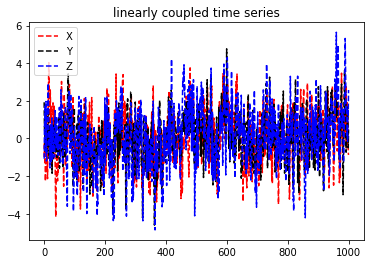

In [112]:
N = 1000    # length of the time series
c1 = 0.5     # coupling strength between time series
c2 = 0.3     # coupling strength between time series

X_linear, Y_linear, Z_linear = linearmodel(N, c1, c2)    # X, Y and Z are the three linearly coupled time series

plt.plot(X_linear,'r--', label='X')
plt.plot(Y_linear, 'k--', label='Y')
plt.plot(Z_linear, 'b--', label='Z')
plt.legend()
plt.title('linearly coupled time series')
plt.show()

## Nonlinear

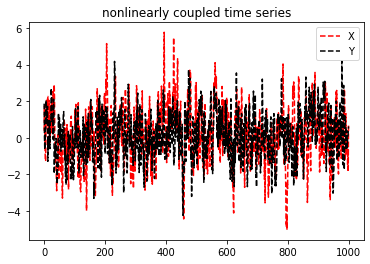

In [146]:
N = 1000    # length of the time series
c = 0.3     # coupling strength between time series


X_nonlinear, Y_nonlinear = nonlinearmodel(N, c)    # X, Y and Z are the three nonlinearly coupled time series

plt.plot(X_nonlinear,'r--', label='X')
plt.plot(Y_nonlinear, 'k--', label='Y')

plt.legend()
plt.title('nonlinearly coupled time series')
plt.show()

# Compute the pTE

## Linear model

In [137]:
time_series_linear = [X_linear, Y_linear, Z_linear]
causality_matrix_linear, surrogate_causality_matrix_linear = pTE(time_series_linear, tau=1, dimEmb=1, surr='iaaft', Nsurr=100)
"""
    tau: lag of the embedding
    dimEmb: dimension of the embedding (model order)
    surr: type of surrogates
    Nsurr: number of surrogates
"""

causality_matrix = 
[[0.00000000e+00 5.56805718e-04 3.10425071e-03]
 [7.94001332e-02 0.00000000e+00 1.33880670e-01]
 [6.54650003e-03 4.11627355e-05 0.00000000e+00]]

surrogate causality matrix = 
[[0.         0.00504761 0.00455064]
 [0.00596872 0.         0.00478544]
 [0.00445406 0.00422419 0.        ]]



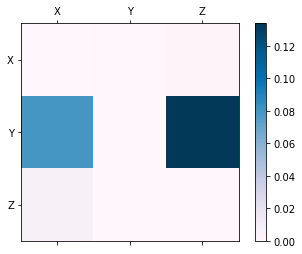

In [138]:
print(f'causality_matrix = \n{causality_matrix_linear}\n')
print(f'surrogate causality matrix = \n{surrogate_causality_matrix_linear}\n')

labels = ['X', 'Y', 'Z']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(causality_matrix_linear, interpolation='nearest', cmap=plt.cm.get_cmap('PuBu'))
fig.colorbar(cax)

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

plt.show()

## Nonlinear model

In [147]:
time_series_nonlinear = [X_nonlinear, Y_nonlinear]
causality_matrix_nonlinear, surrogate_causality_matrix_nonlinear = pTE(time_series_nonlinear, tau=1, dimEmb=1, surr='iaaft', Nsurr=100)
"""
    tau: lag of the embedding
    dimEmb: dimension of the embedding (model order)
    surr: type of surrogates
    Nsurr: number of surrogates
"""

causality_matrix = 
[[0.         0.00012603]
 [0.05941916 0.        ]]

surrogate causality matrix = 
[[0.         0.00548305]
 [0.00539524 0.        ]]



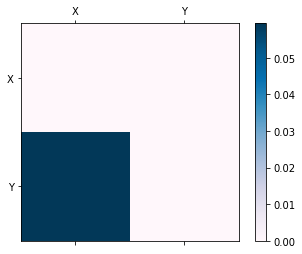

In [148]:
print(f'causality_matrix = \n{causality_matrix_nonlinear}\n')
print(f'surrogate causality matrix = \n{surrogate_causality_matrix_nonlinear}\n')

labels = ['X', 'Y']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(causality_matrix_nonlinear, interpolation='nearest', cmap=plt.cm.get_cmap('PuBu'))
fig.colorbar(cax)

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

plt.show()